In [1]:
import numpy as np
import pandas as pd

## Reading the data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.set_index('PassengerId', inplace = True)
test.set_index('PassengerId', inplace = True)

## Taking a look at the features

In [5]:
train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
train.isna().sum()/len(train) * 100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

There are over 77% values missing in Cabin column. Because of that it might be a good idea to get rid of this features because there may not enough data for our model to find patterns there

In [7]:
train.Ticket.value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [8]:
train.Name

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

It doesn't seem like we will be able to use Ticket and Cabin features, so we will probably drop them... However, we could try to add another feature to data set, which is a name title that we can get from Name column

### Adding Name Title feature

In [9]:
def get_name_titles(names):
    name_titles = []
    for name in names:
        title = name.split(' ')
        for x in title:
            if x.endswith('.'):
                name_titles.append(x[:-1])
                break

    return name_titles

train['NameTitle'] = get_name_titles(list(train.Name))
test['NameTitle'] = get_name_titles(list(test.Name))

Let's see at all of the different titles:

In [10]:
train.NameTitle.value_counts()

NameTitle
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

In [11]:
test.NameTitle.value_counts()

NameTitle
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

There's a Capt title in out training set. Let's see if the captain sunk down along with the ship

In [12]:
train[train.NameTitle == 'Capt']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameTitle
PassengerId,,,,,,,,,,,,
746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0,B22,S,Capt


He did, respect to him

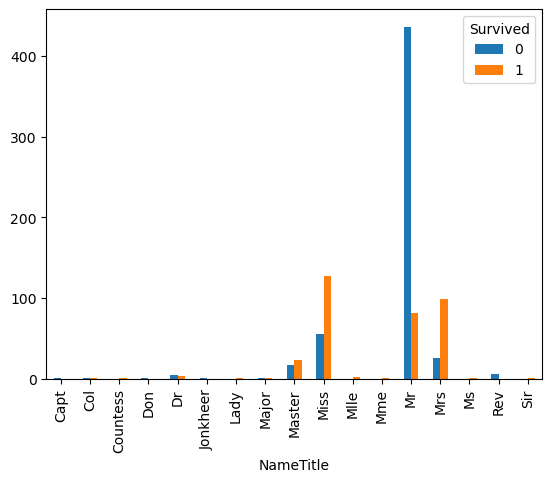

In [13]:
pd.crosstab(train.NameTitle, train.Survived).plot(kind = 'bar');

Clearly women had bigger chance of surviving

There is one problem with those titles however... There are some titles in test set, which don't appear in training set and that makes it different to OneHotEncode.

What I'm gonna do is I'll leave the most common titles like Mr, Miss, Mrs and Master and for every other title I'll asign them to "other" category

In [14]:
common_titles = ['Mr', 'Miss', 'Mrs', 'Master']

def remove_titles(x):
    if x not in common_titles:
        x = 'other'
    return x

train['NameTitle'] = train.NameTitle.apply(remove_titles)
test['NameTitle'] = test.NameTitle.apply(remove_titles)

In [15]:
train.NameTitle.value_counts()

NameTitle
Mr        517
Miss      182
Mrs       125
Master     40
other      27
Name: count, dtype: int64

In [16]:
test.NameTitle.value_counts()

NameTitle
Mr        240
Miss       78
Mrs        72
Master     21
other       7
Name: count, dtype: int64

That takes care of our problem and we will be able to use OneHotEncoding during the preprocessing phase

### Removing features

Now that we've extracted titles from the Name feature, we can now remove it along with Ticket and Cabin features:

In [17]:
features_to_drop = ['Name', 'Ticket', 'Cabin']
train.drop(columns = features_to_drop, inplace = True)
test.drop(columns = features_to_drop, inplace = True)

In [18]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NameTitle
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Mr
2,1,1,female,38.0,1,0,71.2833,C,Mrs
3,1,3,female,26.0,0,0,7.9250,S,Miss
4,1,1,female,35.0,1,0,53.1000,S,Mrs
5,0,3,male,35.0,0,0,8.0500,S,Mr


Let's create histograms with numerical features:

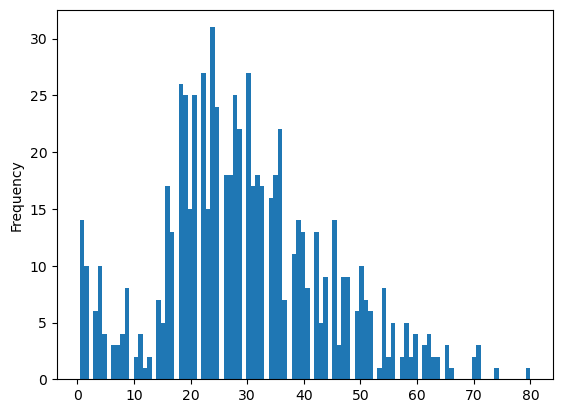

In [19]:
import matplotlib.pyplot as plt

train.Age.plot.hist(bins = 100);

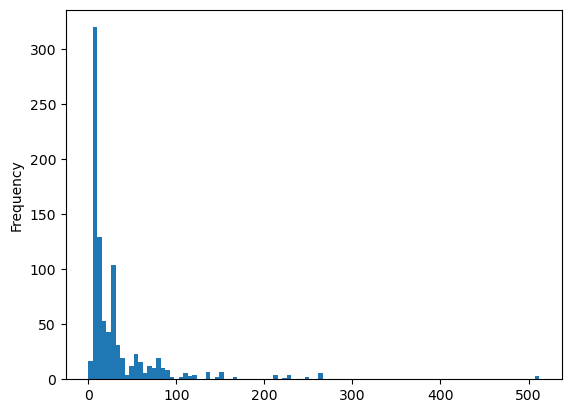

In [20]:
train.Fare.plot.hist(bins = 100);

Since values from Age feature are fairly close to normal distribution, we'll leave it alone, however normalizing Fare feature could benefit our scores

## Creating a function to estimate different models. 
Because the score in the competition is calculated on the percentage of passengers that were correctly predicted, we need to use accuracy_score metric

In [21]:
from sklearn.metrics import accuracy_score
def model_estimation(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

## Creating a pipeline

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

train.dropna(subset = ['Embarked'], inplace = True)

age_feature = ['Age']
age_pipe = Pipeline(steps = [
    ('imputer', SimpleImputer())
])

fare_feature = ['Fare']
fare_pipe = Pipeline(steps = [
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

cat_features = ['Sex', 'Embarked', 'NameTitle']
cat_pipe = Pipeline(steps = [
    ('cat_encoder', OneHotEncoder(handle_unknown = 'ignore'))
])

column_transformer = ColumnTransformer(
    transformers = [
        ('num_transform', age_pipe, age_feature), 
        ('cat_transform', cat_pipe, cat_features), 
        ('fare_normalize', fare_pipe, fare_feature)
    ]
)

model = Pipeline(
    steps = [
        ('preprocessor', column_transformer), 
        ('model', RandomForestClassifier())
    ]
)


## Testing different models on the pipeline

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 1 to 891
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   889 non-null    int64  
 1   Pclass     889 non-null    int64  
 2   Sex        889 non-null    object 
 3   Age        712 non-null    float64
 4   SibSp      889 non-null    int64  
 5   Parch      889 non-null    int64  
 6   Fare       889 non-null    float64
 7   Embarked   889 non-null    object 
 8   NameTitle  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB


In [93]:
X = train.drop('Survived', axis = 1)
X = X.astype({'Sex': 'category', 'Embarked': 'category', 'NameTitle': 'category'})
test = test.astype({'Sex': 'category', 'Embarked': 'category', 'NameTitle': 'category'})
y = train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = .2)

### Testing models on the Pipeline

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier


models = {
    'logistcRegression': LogisticRegression(random_state = 0, max_iter = 1000),
    'linearSVC': LinearSVC(random_state = 0, max_iter = 5000),
    'KNeighbors': KNeighborsClassifier(),
    'SVC': SVC(random_state = 0),
    'GradientBoosting': GradientBoostingClassifier(random_state = 0), 
    'RandomForest': RandomForestClassifier(random_state = 0),
    'XGBoost': XGBClassifier(random_state = 0)
}

models_metrics = {}
validated_models_metrics = {}

for model in models:
    clf = Pipeline(
        steps = [
            ('preprocessor', column_transformer), 
            ('model', models[model])
        ])

    validated_models_metrics[model] = round(np.mean(cross_val_score(clf, X, y, scoring = 'accuracy', cv = 5)), 4)
    models_metrics[model] = round(clf.fit(X_train, y_train).score(X_test, y_test), 4)

print('\nmodels metrics:')    
for key, value in models_metrics.items():
    print(f'{key}: {value}')


print('\ncross-validated models metrics:')
for key, value in validated_models_metrics.items():
    print(f'{key}: {value}')

C:\Users\Kacu\Desktop\data-science\kaggle\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kacu\Desktop\data-science\kaggle\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kacu\Desktop\data-science\kaggle\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kacu\Desktop\data-science\kaggle\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kacu\Desktop\data-science\kaggle\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kacu\Desktop\data-science\


models metrics:
logistcRegression: 0.7135
linearSVC: 0.7191
KNeighbors: 0.7022
SVC: 0.6461
GradientBoosting: 0.7753
RandomForest: 0.736
XGBoost: 0.7416

cross-validated models metrics:
logistcRegression: 0.7863
linearSVC: 0.7885
KNeighbors: 0.7672
SVC: 0.6738
GradientBoosting: 0.8088
RandomForest: 0.7784
XGBoost: 0.8009


### Testing CatBoost

In [29]:
from catboost import CatBoostClassifier

catBoostModel = CatBoostClassifier(random_state = 0, cat_features = ['Sex', 'Embarked', 'NameTitle'])
catBoostMetrics = round(np.mean(cross_val_score(catBoostModel, X, y, cv = 5, verbose = 2, scoring = 'accuracy')), 4)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.008906
0:	learn: 0.6874075	total: 170ms	remaining: 2m 50s
1:	learn: 0.6816690	total: 186ms	remaining: 1m 32s
2:	learn: 0.6768516	total: 197ms	remaining: 1m 5s
3:	learn: 0.6707468	total: 221ms	remaining: 55s
4:	learn: 0.6661396	total: 234ms	remaining: 46.5s
5:	learn: 0.6613185	total: 255ms	remaining: 42.2s
6:	learn: 0.6563341	total: 272ms	remaining: 38.6s
7:	learn: 0.6505141	total: 292ms	remaining: 36.2s
8:	learn: 0.6448043	total: 312ms	remaining: 34.3s
9:	learn: 0.6396600	total: 328ms	remaining: 32.5s
10:	learn: 0.6351672	total: 347ms	remaining: 31.2s
11:	learn: 0.6311905	total: 364ms	remaining: 29.9s
12:	learn: 0.6262848	total: 384ms	remaining: 29.1s
13:	learn: 0.6215448	total: 403ms	remaining: 28.4s
14:	learn: 0.6174160	total: 423ms	remaining: 27.8s
15:	learn: 0.6126836	total: 445ms	remaining: 27.3s
16:	learn: 0.6094231	total: 459ms	remaining: 26.5s
17:	learn: 0.6057923	total: 480ms	remaining: 26.2s
18:	learn: 0.6023118	total: 500ms	remaining: 25.8s
19:	learn: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.9s remaining:    0.0s


10:	learn: 0.6351533	total: 180ms	remaining: 16.2s
11:	learn: 0.6305738	total: 200ms	remaining: 16.5s
12:	learn: 0.6256458	total: 221ms	remaining: 16.8s
13:	learn: 0.6211617	total: 237ms	remaining: 16.7s
14:	learn: 0.6161083	total: 254ms	remaining: 16.7s
15:	learn: 0.6117739	total: 273ms	remaining: 16.8s
16:	learn: 0.6069806	total: 290ms	remaining: 16.8s
17:	learn: 0.6024060	total: 306ms	remaining: 16.7s
18:	learn: 0.5994780	total: 318ms	remaining: 16.4s
19:	learn: 0.5955036	total: 336ms	remaining: 16.5s
20:	learn: 0.5907308	total: 353ms	remaining: 16.5s
21:	learn: 0.5866633	total: 372ms	remaining: 16.5s
22:	learn: 0.5831019	total: 391ms	remaining: 16.6s
23:	learn: 0.5783610	total: 409ms	remaining: 16.6s
24:	learn: 0.5752121	total: 422ms	remaining: 16.5s
25:	learn: 0.5709632	total: 440ms	remaining: 16.5s
26:	learn: 0.5674384	total: 455ms	remaining: 16.4s
27:	learn: 0.5644044	total: 466ms	remaining: 16.2s
28:	learn: 0.5607759	total: 484ms	remaining: 16.2s
29:	learn: 0.5564890	total: 501

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


In [68]:
print(f'CatBoost cross-validated Accuracy: {catBoostMetrics}')

CatBoost cross-validated Accuracy: 0.8201


Default CatBoostClassifier scored a little over 82% accuracy, which is very good

### Testing XGBoost without without a pipeline

Since XGBoost can handle missing values, it's worth to try to test it without using the pipeline

In [52]:
XGBoost_model = XGBClassifier(random_state = 0, enable_categorical = True)
XGBoostMetrics = round(np.mean(cross_val_score(XGBoost_model, X, y, scoring = 'accuracy', cv = 5)), 4)
XGBoostMetrics

0.8223

And with that, XGBoost scores the best accuracy from all of the models!

### Cross-validated accuracy scores on different models
1. logisticRegression: 0.7863,
2. linearSVC: 0.7885,
3. KNeighbors: 0.7672,
4. SVC: 0.6738,
5. GradientBoosting: `0.8088`,
6. RandomForest: 0.7784,
7. CatBoost: `0.8201`,
8. XGBoost:
    - using pipeline 0.8009
    - not using pipeline `0.8223`

Most of our models pefrormed fairly well, however two of them did exceptionally well (CatBoost and XGBoost) scoring over 82% in accuracy on the baseline models

## Improving models

In [27]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [48]:
tuned_models_cv_scores = {}

### Improving XGBoost

#### XGBoost Randomized Search

In [67]:
xgboost_grid = {
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight": [ 1, 3, 5, 7 ],
    "gamma": [0.0, 0.1, 0.2 , 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5 , 0.7] 
}

rs_xgboost = RandomizedSearchCV(XGBoost_model, xgboost_grid, scoring = 'accuracy', n_iter = 200, cv = 5, verbose = 2)
rs_xgboost_preds = rs_xgboost.fit(X_train, y_train).predict(X_test)
rs_xgboost_metrics = model_estimation(y_test, rs_xgboost_preds)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1; total time=   0.0s
[CV] END colsample_bytree=0.3, g

In [68]:
rs_xgboost_metrics

0.7696629213483146

In [69]:
rs_xgboost.best_params_

{'min_child_weight': 3,
 'max_depth': 10,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'colsample_bytree': 0.4}

#### XGBoost GridSearch

In [71]:
xgboost_grid = {
    "learning_rate": [0.10, 0.15, 0.20, 0.25],
    "max_depth": [6, 8, 10, 12],
    "min_child_weight": [1, 3],
    "gamma": [0.0, 0.1, 0.2 , 0.3],
    "colsample_bytree": [0.3, 0.4, 0.5] 
}

gs_xgboost = GridSearchCV(XGBoost_model, xgboost_grid, scoring = 'accuracy', cv = 5, verbose = 2)
gs_xgboost_preds = gs_xgboost.fit(X_train, y_train).predict(X_test)
gs_xgboost_metrics = model_estimation(y_test, gs_xgboost_preds)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3; total time=   0.0s
[CV] END colsample_bytree=0.3, g

In [72]:
gs_xgboost_metrics

0.7752808988764045

In [90]:
gs_xgboost.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.2,
 'learning_rate': 0.25,
 'max_depth': 12,
 'min_child_weight': 3}

Okay, now let's use these hyperparameters and see how will the cross-validated metric improve

In [35]:
tuned_xgboost = XGBClassifier(colsample_bytree = .5, 
                              gamma = .2, 
                              learning_rate = .25, 
                              max_depth = 12, 
                              min_child_weight = 3,
                              enable_categorical = True, 
                              random_state = 0,)


tuned_xgboost_cv_score = round(np.mean(cross_val_score(tuned_xgboost, X, y, scoring = 'accuracy', cv = 5)), 4)

In [50]:
print(tuned_xgboost_cv_score)
tuned_models_cv_scores['xgboost'] = tuned_xgboost_cv_score

0.8414


Nice! We managed to improve our cross-validated score of xgboost by almost 2%!

Now let's try to improve RandomForest. Despite not achieving the best score compared to other models, it's still worth trying to improve it and seeing how it goes

In [39]:
# First, let's create a simple function, which will help us to create pipelines with different models
def create_pipeline_model(clf):
    model = Pipeline(
        steps = [
            ('preprocessor', column_transformer), 
            ('model', clf)
        ])
    return model

### Improving RandomForestClassifier

#### Random Forest Randomized Search

In [107]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model = create_pipeline_model(RandomForestClassifier(random_state = 0))

pipe_grid = {
    'preprocessor__num_transform__imputer__strategy': ['mean', 'median'],
    'model__n_estimators': np.arange(200, 1601, 200),
    'model__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'model__max_features': [None, 'sqrt'],
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_samples_split': [2, 4, 6],
    'model__bootstrap': [True, False]
}

rs_rf_model = RandomizedSearchCV(model, pipe_grid, scoring = 'accuracy', cv = 5, n_iter = 200, verbose = 2)
rf_y_preds = rs_rf_model.fit(X_train, y_train).predict(X_test)

rs_RandomForest_metrics = model_estimation(y_test, rf_y_preds)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END model__bootstrap=False, model__max_depth=100, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=6, model__n_estimators=400, preprocessor__num_transform__imputer__strategy=median; total time=   0.6s
[CV] END model__bootstrap=False, model__max_depth=100, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=6, model__n_estimators=400, preprocessor__num_transform__imputer__strategy=median; total time=   0.6s
[CV] END model__bootstrap=False, model__max_depth=100, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=6, model__n_estimators=400, preprocessor__num_transform__imputer__strategy=median; total time=   0.6s
[CV] END model__bootstrap=False, model__max_depth=100, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=6, model__n_estimators=400, preprocessor__num_transform__imputer__strategy=median; total time=   0

In [110]:
# gs_model.score(X_test, y_test)
rs_RandomForest_metrics

0.7471910112359551

In [111]:
rs_rf_model.best_params_

{'preprocessor__num_transform__imputer__strategy': 'mean',
 'model__n_estimators': 200,
 'model__min_samples_split': 6,
 'model__min_samples_leaf': 4,
 'model__max_features': 'sqrt',
 'model__max_depth': 50,
 'model__bootstrap': False}

In [113]:
tuned_rf_model = RandomForestClassifier(n_estimators = 200, 
                                  min_samples_split = 6, 
                                  min_samples_leaf = 4, 
                                  max_features = 'sqrt', 
                                  max_depth = 50, 
                                  bootstrap = False, 
                                  random_state = 0)

tuned_rf = create_pipeline_model(tuned_rf_model)

round(np.mean(cross_val_score(tuned_rf, X, y, scoring = 'accuracy', cv = 5)), 4)

0.8099

Over 80% accuracy on cross-validation score, let's see if we can further improve it after performing a Grid Search on this model

#### Random Forest Grid Search

In [31]:
model = create_pipeline_model(RandomForestClassifier(random_state = 0))

pipe_grid = {
    'preprocessor__num_transform__imputer__strategy': ['mean', 'median'],
    'model__n_estimators': np.arange(100, 401, 100),
    'model__max_depth': [40, 50, 60, 70, None],
    'model__max_features': [None, 'sqrt'],
    'model__min_samples_leaf': [2, 4, 6],
    'model__min_samples_split': [4, 6, 8],
    'model__bootstrap': [False]
}

gs_rf_model = GridSearchCV(model, pipe_grid, scoring = 'accuracy', cv = 5, verbose = 2)
rf_y_preds = gs_rf_model.fit(X_train, y_train).predict(X_test)

gs_RandomForest_metrics = model_estimation(y_test, rf_y_preds)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV] END model__bootstrap=False, model__max_depth=40, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=mean; total time=   0.1s
[CV] END model__bootstrap=False, model__max_depth=40, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=mean; total time=   0.1s
[CV] END model__bootstrap=False, model__max_depth=40, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=mean; total time=   0.1s
[CV] END model__bootstrap=False, model__max_depth=40, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=mean; total time=   0.1s
[CV] END

In [33]:
gs_RandomForest_metrics

0.7471910112359551

In [32]:
gs_rf_model.best_params_

{'model__bootstrap': False,
 'model__max_depth': 40,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 4,
 'model__n_estimators': 200,
 'preprocessor__num_transform__imputer__strategy': 'mean'}

In [40]:
tuned_rf_model = RandomForestClassifier(n_estimators = 200, 
                                  min_samples_split = 4, 
                                  min_samples_leaf = 4, 
                                  max_features = 'sqrt', 
                                  max_depth = 40, 
                                  bootstrap = False, 
                                  random_state = 0)

tuned_rf = create_pipeline_model(tuned_rf_model)

tuned_rf_cv_score = round(np.mean(cross_val_score(tuned_rf, X, y, scoring = 'accuracy', cv = 5)), 4)

In [51]:
print(tuned_rf_cv_score)
tuned_models_cv_scores['Random Forest'] = tuned_rf_cv_score

0.8099


Okay, seems like GridSearch couldn't find better hyperparameters - cross-validated accuracy score is the same

### Improving GradientBoosting model

#### GrandientBoosting Random Search

In [31]:
model = create_pipeline_model(GradientBoostingClassifier(random_state = 0))

gb_search_pipe = {
    'preprocessor__num_transform__imputer__strategy': ['median', 'mean'],
    'model__n_estimators': [100, 200, 300, 400, 500], 
    'model__loss': ['log_loss', 'exponential'],
    'model__max_features': [None, 'sqrt', 'log2'],
    "model__learning_rate": [0.01, .2, 0.075, 0.1],
    'model__min_samples_split': [2, 4, 6]
}

rs_gb_model = RandomizedSearchCV(model, gb_search_pipe, verbose = 2, cv = 5, n_iter = 200)
gb_y_preds = rs_gb_model.fit(X_train, y_train).predict(X_test)

rs_GradientBoosting_metrics = model_estimation(y_test, gb_y_preds)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END model__learning_rate=0.075, model__loss=log_loss, model__max_features=None, model__min_samples_split=4, model__n_estimators=200, preprocessor__num_transform__imputer__strategy=median; total time=   0.2s
[CV] END model__learning_rate=0.075, model__loss=log_loss, model__max_features=None, model__min_samples_split=4, model__n_estimators=200, preprocessor__num_transform__imputer__strategy=median; total time=   0.2s
[CV] END model__learning_rate=0.075, model__loss=log_loss, model__max_features=None, model__min_samples_split=4, model__n_estimators=200, preprocessor__num_transform__imputer__strategy=median; total time=   0.1s
[CV] END model__learning_rate=0.075, model__loss=log_loss, model__max_features=None, model__min_samples_split=4, model__n_estimators=200, preprocessor__num_transform__imputer__strategy=median; total time=   0.1s
[CV] END model__learning_rate=0.075, model__loss=log_loss, model__max_features=None, mod

In [32]:
rs_gb_model.best_params_

{'preprocessor__num_transform__imputer__strategy': 'median',
 'model__n_estimators': 200,
 'model__min_samples_split': 4,
 'model__max_features': None,
 'model__loss': 'log_loss',
 'model__learning_rate': 0.075}

In [33]:
rs_GradientBoosting_metrics

0.7865168539325843

#### GradientBoosting GridSearch

In [35]:
model = create_pipeline_model(GradientBoostingClassifier(random_state = 0))

gb_search_pipe = {
    'preprocessor__num_transform__imputer__strategy': ['median'],
    'model__n_estimators': [100, 200, 300, 400], 
    'model__loss': ['log_loss'],
    'model__max_features': [None, 'sqrt', 'log2'],
    "model__learning_rate": [.2, 0.075, 0.1],
    'model__min_samples_split': [2, 4, 6]
}

gs_gb_model = GridSearchCV(model, gb_search_pipe, verbose = 2, cv = 5)
gb_y_preds = gs_gb_model.fit(X_train, y_train).predict(X_test)

gs_GradientBoosting_metrics = model_estimation(y_test, gb_y_preds)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END model__learning_rate=0.2, model__loss=log_loss, model__max_features=None, model__min_samples_split=2, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=median; total time=   0.1s
[CV] END model__learning_rate=0.2, model__loss=log_loss, model__max_features=None, model__min_samples_split=2, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=median; total time=   0.1s
[CV] END model__learning_rate=0.2, model__loss=log_loss, model__max_features=None, model__min_samples_split=2, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=median; total time=   0.1s
[CV] END model__learning_rate=0.2, model__loss=log_loss, model__max_features=None, model__min_samples_split=2, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=median; total time=   0.1s
[CV] END model__learning_rate=0.2, model__loss=log_loss, model__max_features=None, model__min_sam

In [37]:
gs_GradientBoosting_metrics

0.7865168539325843

In [36]:
gs_gb_model.best_params_

{'model__learning_rate': 0.075,
 'model__loss': 'log_loss',
 'model__max_features': None,
 'model__min_samples_split': 4,
 'model__n_estimators': 200,
 'preprocessor__num_transform__imputer__strategy': 'median'}

Grid Search didn't find better hyperparameters, let's try them then

In [62]:
gb_model = model
gb_model.set_params(preprocessor__num_transform__imputer__strategy = 'median')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'NameTitle']),
                                                 ('fare_normalize',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Fare'])])),
                ('model', GradientBoostingClassifier(random_state=0))])

In [43]:
tuned_gb_model = GradientBoostingClassifier(learning_rate = 0.075,
                                                 loss = 'log_loss',
                                                 max_features = None, 
                                                 min_samples_split = 4, 
                                                 n_estimators = 200,
                                                 random_state = 0)


tuned_gb = create_pipeline_model(tuned_gb_model)

tuned_gb_cv_score = round(np.mean(cross_val_score(tuned_gb, X, y, scoring = 'accuracy', cv = 5)), 4)

In [52]:
print(tuned_gb_cv_score)
tuned_models_cv_scores['Gradient Boosting'] = tuned_gb_cv_score

0.8144


Gradient Boost improved slightly (baseseline model already scored over 80%)

In [65]:
model.set_params(preprocessor__num_transform__imputer__strategy = 'mean')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'NameTitle']),
                                                 ('fare_normalize',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Fare'])])),
                ('model', GradientBoostingClassifier(random_state=0))])

### Improving CatBoost model

In [31]:
pipe_grid = {
    'iterations': [300, 400, 500, 600, 700], 
    'depth': [6, 7, 8, 9, 10],
    'l2_leaf_reg': [2, 3, 4]
}

rs_cb_model = RandomizedSearchCV(catBoostModel, pipe_grid, scoring = 'accuracy', cv = 5, n_iter = 5, verbose = 2)
cb_y_preds = rs_cb_model.fit(X_train, y_train).predict(X_test)

rs_catBoost_metrics = model_estimation(y_test, cb_y_preds)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0:	learn: 0.6699383	total: 33.5ms	remaining: 13.4s
1:	learn: 0.6516156	total: 48.9ms	remaining: 9.74s
2:	learn: 0.6327444	total: 73.4ms	remaining: 9.71s
3:	learn: 0.6114705	total: 103ms	remaining: 10.2s
4:	learn: 0.5937699	total: 126ms	remaining: 9.95s
5:	learn: 0.5805729	total: 157ms	remaining: 10.3s
6:	learn: 0.5634339	total: 185ms	remaining: 10.4s
7:	learn: 0.5512245	total: 202ms	remaining: 9.88s
8:	learn: 0.5383105	total: 228ms	remaining: 9.89s
9:	learn: 0.5308526	total: 241ms	remaining: 9.39s
10:	learn: 0.5180211	total: 266ms	remaining: 9.4s
11:	learn: 0.5121328	total: 276ms	remaining: 8.94s
12:	learn: 0.5046482	total: 294ms	remaining: 8.76s
13:	learn: 0.4971211	total: 304ms	remaining: 8.38s
14:	learn: 0.4858630	total: 329ms	remaining: 8.45s
15:	learn: 0.4804968	total: 340ms	remaining: 8.15s
16:	learn: 0.4736663	total: 358ms	remaining: 8.07s
17:	learn: 0.4680710	total: 374ms	remaining: 7.94s
18:	learn: 0.4621759	total: 38

In [32]:
rs_catBoost_metrics

0.7359550561797753

In [33]:
rs_cb_model.best_params_

{'l2_leaf_reg': 4, 'iterations': 400, 'depth': 10}

In [45]:
tuned_cb = CatBoostClassifier(iterations = 400, l2_leaf_reg = 4, depth = 10, random_state = 0, cat_features = ['Sex', 'Embarked', 'NameTitle'])
tuned_cb_cv_score = round(np.mean(cross_val_score(tuned_cb, X, y, cv = 5, verbose = 2, scoring = 'accuracy')), 4)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 0.6702910	total: 39.6ms	remaining: 15.8s
1:	learn: 0.6557597	total: 55.1ms	remaining: 11s
2:	learn: 0.6423139	total: 66.3ms	remaining: 8.78s
3:	learn: 0.6260981	total: 85.9ms	remaining: 8.5s
4:	learn: 0.6135418	total: 96.7ms	remaining: 7.64s
5:	learn: 0.5978652	total: 144ms	remaining: 9.44s
6:	learn: 0.5861275	total: 163ms	remaining: 9.14s
7:	learn: 0.5713801	total: 207ms	remaining: 10.1s
8:	learn: 0.5580770	total: 246ms	remaining: 10.7s
9:	learn: 0.5472773	total: 264ms	remaining: 10.3s
10:	learn: 0.5366799	total: 303ms	remaining: 10.7s
11:	learn: 0.5302640	total: 317ms	remaining: 10.2s
12:	learn: 0.5207089	total: 347ms	remaining: 10.3s
13:	learn: 0.5116056	total: 385ms	remaining: 10.6s
14:	learn: 0.5039462	total: 411ms	remaining: 10.6s
15:	learn: 0.4998840	total: 421ms	remaining: 10.1s
16:	learn: 0.4904443	total: 460ms	remaining: 10.4s
17:	learn: 0.4869610	total: 471ms	remaining: 9.99s
18:	learn: 0.4826496	total: 490ms	remaining: 9.82s
19:	learn: 0.4797063	total: 498ms	remai

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.9s remaining:    0.0s


8:	learn: 0.5585119	total: 206ms	remaining: 8.95s
9:	learn: 0.5452598	total: 247ms	remaining: 9.63s
10:	learn: 0.5327493	total: 285ms	remaining: 10.1s
11:	learn: 0.5250669	total: 298ms	remaining: 9.65s
12:	learn: 0.5179492	total: 312ms	remaining: 9.28s
13:	learn: 0.5088113	total: 331ms	remaining: 9.11s
14:	learn: 0.4978966	total: 370ms	remaining: 9.51s
15:	learn: 0.4886028	total: 409ms	remaining: 9.81s
16:	learn: 0.4799184	total: 442ms	remaining: 9.95s
17:	learn: 0.4763721	total: 452ms	remaining: 9.6s
18:	learn: 0.4676681	total: 478ms	remaining: 9.59s
19:	learn: 0.4595218	total: 517ms	remaining: 9.81s
20:	learn: 0.4521231	total: 555ms	remaining: 10s
21:	learn: 0.4456229	total: 593ms	remaining: 10.2s
22:	learn: 0.4392229	total: 624ms	remaining: 10.2s
23:	learn: 0.4342984	total: 663ms	remaining: 10.4s
24:	learn: 0.4323199	total: 671ms	remaining: 10.1s
25:	learn: 0.4303726	total: 682ms	remaining: 9.81s
26:	learn: 0.4254268	total: 721ms	remaining: 9.96s
27:	learn: 0.4205936	total: 759ms	re

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


In [53]:
print(tuned_cb_cv_score)
tuned_models_cv_scores['catBoost'] = tuned_cb_cv_score

0.8347


### Comparing tuned models

First, let's see our baseline cv scores:

In [47]:
for key, value in validated_models_metrics.items():
    print(f'{key}: {value}')

logistcRegression: 0.7863
linearSVC: 0.7885
KNeighbors: 0.7672
SVC: 0.6738
GradientBoosting: 0.8088
RandomForest: 0.7784
XGBoost: 0.8009


In [54]:
for key, value in tuned_models_cv_scores.items():
    print(f'{key}: {value}')

xgboost: 0.8414
Random Forest: 0.8099
Gradient Boosting: 0.8144
catBoost: 0.8347


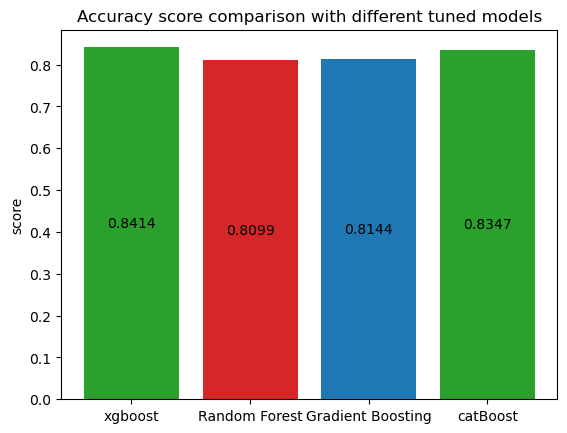

In [64]:
fig, ax = plt.subplots()

models = tuned_models_cv_scores.keys()
scores = tuned_models_cv_scores.values()
bar_colors = ['tab:green', 'tab:red', 'tab:blue', 'tab:green']

p = ax.bar(models, scores, color = bar_colors)

ax.set_ylabel('score')
ax.bar_label(p, label_type='center')
plt.title('Accuracy score comparison with different tuned models')
plt.show()

XGBClassifier performs the best, and most likely, I will use this model to predict the final score in this competition

In [76]:
feature_importances = tuned_xgboost.fit(X_train, y_train).feature_importances_
feature_importances

array([0.08777092, 0.42522144, 0.02803434, 0.05683178, 0.02447378,
       0.02745176, 0.0271789 , 0.32303703], dtype=float32)

In [77]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'NameTitle'],
      dtype='object')

#### XGBoost feature importances plot

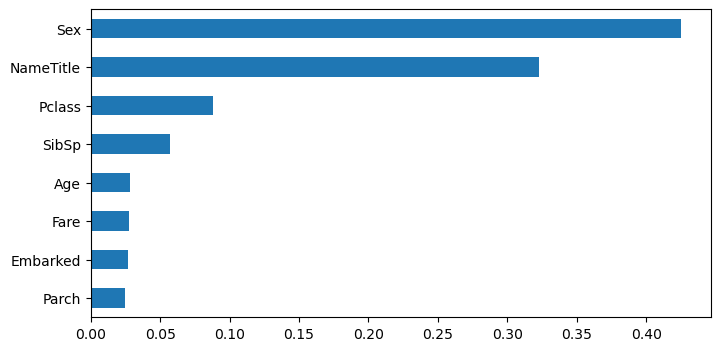

In [91]:
xgb_importances = pd.Series(feature_importances, X_train.columns).sort_values(ascending = True)

fig, ax = plt.subplots(figsize = (8, 4))
p = xgb_importances.plot.barh()
plt.show()

## Predicting the test set

In [120]:
xgb_preds = tuned_xgboost.fit(X_train, y_train).predict(test)
xgb_preds

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [121]:
solution = pd.DataFrame({'PassengerID': test.index, 'Survived': xgb_preds})
solution

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [122]:
solution.to_csv('titanic_xgb_solution.csv', header=True, index=None)